5η υπο-εργασία (association rule mining): Να εξάγετε κανόνες συσχέτισης απ’ τα δεδομένα σας, χρησιμοποιώντας τον αλγόριθμο Apriori με το confidence ως μετρική. Αναγνωρίστε τις περιπτώσεις με τα υψηλότερα confidences και σχολιάστε τ’ αποτελέσματά σας.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')
sns.set_palette("rainbow")

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [3]:
#data_path = 'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
columns = 'age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target'.split(',')

heart_disease = pd.read_csv('processed.cleveland.data', names=columns)
print(f'Rows: {heart_disease.shape[0]}\nColumns: {heart_disease.shape[1]}')
heart_disease.head()

Rows: 303
Columns: 14
age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca           object
thal         object
target        int64
dtype: object


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


# Part 1 & 2 

In [4]:
heart_disease['target'] = heart_disease['target'].map(lambda x:0 if x==0 else 1)

In [5]:
#Missing Values : Replace '?' with None
for column in heart_disease.select_dtypes('object'):
    heart_disease[column] = heart_disease[column].replace('?', np.nan).astype(float)

#Fill in None with most frequent value
heart_disease["ca"] = heart_disease["ca"].fillna(heart_disease['ca'].mode()[0])
heart_disease["thal"] = heart_disease["thal"].fillna(heart_disease['thal'].mode()[0])

#Turn object type into integers
heart_disease['ca'] = heart_disease['ca'].astype(float).astype(int)
heart_disease['thal'] = heart_disease['thal'].astype(float).astype(int)

In [6]:
#Standardization
columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
scaler = StandardScaler()
heart_disease.loc[:,columns] = scaler.fit_transform(heart_disease.loc[:,columns]) #this gives us back a dataframe

# Part 5 

In [7]:
#Πρέπει να αλλάξουμε τα ονόματα όλων των τιμών προκειμένου να βλέπουμε ξεκάθαρα ποια itemsets εμφανίζονται κάθε φορά. 
#Ξεκινάμε με τις κατηγορικές μεταβλητές (και τις binary) : 

heart_disease['sex'].replace({1: "male", 0: "female"}, inplace=True)
heart_disease['cp'].replace({1: "typical", 2: "atypical", 3: "non anginal", 4: "asymptomatic"}, inplace=True)
heart_disease['fbs'].replace({1:"> 120 mg/dl", 0:"<= 120 mg/dl"}, inplace=True)
heart_disease['restecg'].replace({0: "normal", 1: "abnormality", 2: "hypertrophy"}, inplace=True)
heart_disease['exang'].replace({1:'yes',0:'no'}, inplace=True)
heart_disease['slope'].replace({1: "up", 2: "flat", 3: "down"}, inplace=True)
heart_disease['ca'].replace({0: "0 vessels", 1: "1 vessel", 2: "2 vessels", 3: "3 vessels"}, inplace=True)
heart_disease['thal'].replace({3: "normal", 6: "fixed", 7: "reversable"}, inplace=True)
heart_disease['target'].replace({0: "no heart disease", 1: "heart_disease"}, inplace=True)

In [8]:
#Έπειτα, προχωράμε στις συνεχείς. Πριν τους αλλάξουμε όνομα, θα επιχειρίσουμε να τις χωρίσουμε σε bins, έτσι ώστε να 
#έχουμε πιο ξεκάθαρη διαχώριση μεταξύ τους.
#Βλέπουμε πόσες μοναδικές τιμές έχει η κάθε συνεχής μεταβλητή. Με βάση τις τιμές αυτές, χωρίζουμε ανάλογα σε bins
columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
for x in columns:
    print(x,heart_disease[x].nunique())
    
heart_disease['age'] = pd.qcut(heart_disease['age'], q=3, duplicates='drop')
heart_disease['trestbps'] = pd.qcut(heart_disease['trestbps'], q=2, duplicates='drop')
heart_disease['chol'] = pd.qcut(heart_disease['chol'], q=3, duplicates='drop')
heart_disease['thalach'] = pd.qcut(heart_disease['thalach'], q=3, duplicates='drop')
heart_disease['oldpeak'] = pd.qcut(heart_disease['oldpeak'], q=2, duplicates='drop')

#΄Τέλος, αλλάζουμε τα ονόματα όλων των τιμών 
heart_disease = heart_disease.astype(str)
for col in heart_disease.columns:
    heart_disease[col] = [col + '=' + x for x in heart_disease[col]]

age 41
trestbps 50
chol 152
thalach 91
oldpeak 40


In [9]:
heart_disease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,"age=(0.505, 2.5]",sex=male,cp=typical,"trestbps=(-0.0962, 3.888]","chol=(-0.478, 0.322]",fbs=> 120 mg/dl,restecg=hypertrophy,"thalach=(-0.289, 0.543]",exang=no,"oldpeak=(-0.207, 4.452]",slope=down,ca=-0.7111313860964096,thal=fixed,target=no heart disease
1,"age=(0.505, 2.5]",sex=male,cp=asymptomatic,"trestbps=(-0.0962, 3.888]","chol=(0.322, 6.138]",fbs=<= 120 mg/dl,restecg=hypertrophy,"thalach=(-3.443, -0.289]",exang=yes,"oldpeak=(-0.207, 4.452]",slope=flat,ca=2.504880703264965,thal=normal,target=heart_disease
2,"age=(0.505, 2.5]",sex=male,cp=asymptomatic,"trestbps=(-2.146, -0.0962]","chol=(-0.478, 0.322]",fbs=<= 120 mg/dl,restecg=hypertrophy,"thalach=(-3.443, -0.289]",exang=yes,"oldpeak=(-0.207, 4.452]",slope=flat,ca=1.43287667347784,thal=reversable,target=heart_disease
3,"age=(-2.82, -0.381]",sex=male,cp=non anginal,"trestbps=(-2.146, -0.0962]","chol=(-0.478, 0.322]",fbs=<= 120 mg/dl,restecg=normal,"thalach=(0.543, 2.294]",exang=no,"oldpeak=(-0.207, 4.452]",slope=down,ca=-0.7111313860964096,thal=normal,target=no heart disease
4,"age=(-2.82, -0.381]",sex=female,cp=atypical,"trestbps=(-2.146, -0.0962]","chol=(-2.336, -0.478]",fbs=<= 120 mg/dl,restecg=hypertrophy,"thalach=(0.543, 2.294]",exang=no,"oldpeak=(-0.207, 4.452]",slope=up,ca=-0.7111313860964096,thal=normal,target=no heart disease


# Association Rules 

In [10]:
hd_list = heart_disease.values.tolist()

trans_enc = TransactionEncoder()
hd_array = trans_enc.fit(hd_list).transform(hd_list)

hd_df = pd.DataFrame(hd_array, columns = trans_enc.columns_ )

In [11]:
freq = apriori(hd_df, min_support=0.5, use_colnames=True)
freq.sort_values('support', ascending=False)

,support,itemsets
2,0.851485,(fbs=<= 120 mg/dl)
4,0.679868,(sex=male)
1,0.673267,(exang=no)
0,0.594059,(ca=-0.7111313860964096)
9,0.577558,"(exang=no, fbs=<= 120 mg/dl)"
10,0.570957,"(sex=male, fbs=<= 120 mg/dl)"
7,0.564356,"(trestbps=(-2.146, -0.0962])"
6,0.554455,(thal=normal)
5,0.541254,(target=no heart disease)
3,0.537954,"(oldpeak=(-0.898, -0.207])"


In [12]:
rules = association_rules(freq, metric="confidence", min_threshold=0.7)
print(rules)
print(f'We have {len(rules)} rules.')

                antecedents         consequents  antecedent support  \
0  (ca=-0.7111313860964096)  (fbs=<= 120 mg/dl)            0.594059   
1                (exang=no)  (fbs=<= 120 mg/dl)            0.673267   
2                (sex=male)  (fbs=<= 120 mg/dl)            0.679868   

   consequent support   support  confidence      lift  leverage  conviction  
0            0.851485  0.524752    0.883333  1.037403  0.018920    1.272984  
1            0.851485  0.577558    0.857843  1.007467  0.004281    1.044725  
2            0.851485  0.570957    0.839806  0.986284 -0.007940    0.927093  
We have 3 rules.


Text(0.5, 1.0, '(sex=male, fbs<= 120 mg/dl)')

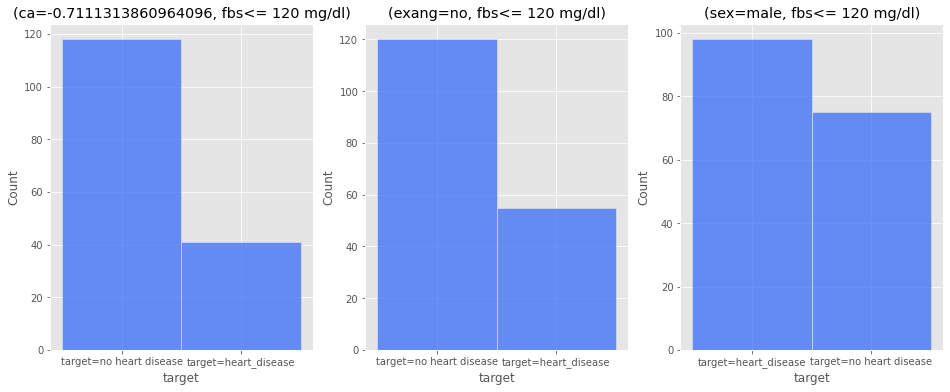

In [13]:
#Βλέπουμε ότι η τιμή fbs είναι και στα 3 συχνότερα itemsets. Ας δούμε πως αλλάζει η target για κάθε τιμή που εμφανίζεται
#μαζί της. 
fig, axes = plt.subplots(1,3, figsize=(16, 6))

sns.histplot(ax=axes[0], x='target', 
            data = heart_disease[(heart_disease['ca']== 'ca=-0.7111313860964096') & 
                                 (heart_disease['fbs']=='fbs=<= 120 mg/dl')],)
sns.histplot(ax=axes[1], x='target', 
            data = heart_disease[(heart_disease['exang']== 'exang=no') & 
                                 (heart_disease['fbs']=='fbs=<= 120 mg/dl')])
sns.histplot(ax=axes[2], x='target', 
            data = heart_disease[(heart_disease['sex']== 'sex=male') & 
                                 (heart_disease['fbs']=='fbs=<= 120 mg/dl')])

axes[0].set_title('(ca=-0.7111313860964096, fbs<= 120 mg/dl)')
axes[1].set_title('(exang=no, fbs<= 120 mg/dl)')
axes[2].set_title('(sex=male, fbs<= 120 mg/dl)')